In [16]:
import numpy as np
from math import *
from operator import add
from scipy.stats import norm
import matplotlib.pyplot as plt

In [17]:
def y_calc(w, C, d, h, N, A, dim):
    if (dim == 1):
        return h*sum(np.multiply(w, C))+d
    if (dim == 2):
        r=np.linspace(0, A, N)
        return 2*pi*h*sum(np.multiply(w, C))+d
    if (dim == 3):
        r=np.linspace(0, A, N)
        return 4*pi*h*sum(np.multiply(w, np.multiply(C, np.multiply(r, r))))+d

In [18]:
def n_calc(D11, D12, D22, w11, w12, w21, w22, d11, d12, d21, d22, b1, b2, d1, d2, h, A, N, dim):
    left=np.array([b1-d1, b2-d2]);
    y11=y_calc(w11, D11, d11, h, N, A, dim);
    y12=y_calc(w12, D12, d12, h, N, A, dim);
    y21=y_calc(w21, D12, d21, h, N, A, dim);
    y22=y_calc(w22, D22, d22, h, N, A, dim);
    right=np.array([[y11, y12], [y21, y22]]);
    res=np.linalg.solve(right, left)
    return res[0], res[1]


In [19]:
def conv_dim(u, v, N, A, dim, ft):
    if (dim == 1):
        res=np.convolve(u, v, 'same')
    if (dim == 2):
        r=np.linspace(0, A, N)
        k=pi/A*r
        u1=ft.transform(u, k, ret_err=False)
        v1=ft.transform(v, k, ret_err=False)
        uv=np.multiply(u1, v1)
        res=ft.transform(uv, r, ret_err=False, inverse=True)
    if (dim == 3):
        r=np.linspace(0, A, N)
        res=4*pi*np.convolve(np.multiply(u, r), v, 'same')
    return res

In [20]:
def d11_calc(D11, D12, m1, w11, w12, b1, d1, d11, d12, N1, N2, al, A, N, dim, ft):
    left=np.array([((1-al/2)*b1+al/2*(d1+d11*N1+N2*d12))]*N)+w11
    right=conv_dim(m1, D11, N, A, dim, ft)
    temp= np.multiply(D11+np.array([2]*N), conv_dim(w11, D11, N, A, dim, ft))+conv_dim(np.multiply(w11, D11), D11, N, A, dim, ft)
    temp=(-al)/2*N1*temp
    right=right+temp
    temp= np.multiply(D11+np.array([2]*N), conv_dim(w12, D12, N, A, dim, ft))+conv_dim(np.multiply(w12, D12), D12, N, A, dim, ft)
    temp=(-al)/2*N2*temp
    right=right+temp+(1/N1)*m1-w11
    return np.divide(right, left)

In [21]:
def d12_calc(D12, D11, D22, m1, m2, w11, w12, w21, w22, b1, b2, d1, d2, d11, d12, d21, d22, N1, N2, al, A, N, dim, ft):
    left=np.array([(1-al/2)*(b1+b2)+al/2*(d1+d2+N1*(d11+d21)+N2*(d12+d22))]*N)+w12+w21
    right=conv_dim(m1+m2, D12, N, A, dim, ft)
    temp=np.multiply(D12+np.array([2]*N), conv_dim(w11, D12, N, A, dim, ft)+conv_dim(w21, D11, N, A, dim, ft))+conv_dim(np.multiply(w21, D12), D11, N, A, dim, ft)+conv_dim(np.multiply(w11, D11), D12, N, A, dim, ft)
    temp=(-al/2)*N1*temp
    right=right+temp
    temp=np.multiply(D12+np.array([2]*N), conv_dim(w11, D22, N, A, dim, ft)+conv_dim(w22, D12, N, A, dim, ft))+conv_dim(np.multiply(w22, D22), D12, N, A, dim, ft)+conv_dim(np.multiply(w12, D12), D22, N, A, dim, ft)
    temp=(-al/2)*N2*temp
    right=right+temp-w12-w21
    return np.divide(right, left)

In [22]:
def d22_calc(D22, D12, m2, w22, w21, b2, d2, d22, d21, N2, N1, al, A, N, dim, ft):
    left=np.array([((1-al/2)*b2+al/2*(d2+d21*N1+N2*d22))]*N)+d22
    right=conv_dim(m2, D22, N, A, dim, ft)
    temp= np.multiply(D22+np.array([2]*N), conv_dim(w22, D22, N, A, dim, ft))+conv_dim(np.multiply(w22, D22), D22, N, A, dim, ft)
    temp=(-al)/2*N2*temp
    right=right+temp
    temp= np.multiply(D22+np.array([2]*N), conv_dim(w21, D12, N, A, dim, ft))+conv_dim(np.multiply(w21, D12), D12, N, A, dim, ft)
    temp=(-al)/2*N1*temp
    right=right+temp-(1/N2)*m2-w22
    return np.divide(right, left)

In [23]:
def solver(N1, N2, D11, D12, D22, w11, w12, w21, w22, d11, d12, d21, d22, m1, m2, b1, b2, d1, d2, h, A, al, N, dim):
    from hankel.hankel import SymmetricFourierTransform
    eps2=1e-4
    eps=1e-8
    max_iter=500
    y11_old=1; y12_old=1; y21_old=1; y22_old=1; mistake=1;
    n1_old=100000; n2_old=100000; mistake2=1000;
    itr=0
    ft=0
    if (dim == 2):
        ft = SymmetricFourierTransform(dim, N, h)
    while ((mistake > eps) and (itr < max_iter) and (mistake2 > eps2)):
        D12=d12_calc(D12, D11, D22, m1, m2, w11, w12, w21, w22, b1, b2, d1, d2, d11, d12, d21, d22, N1, N2, al, A, N, dim, ft)
        N1, N2=n_calc(D11, D12, D22, w11, w12, w21, w22, d11, d12, d21, d22, b1, b2, d1, d2, h, A, N, dim)
        D11=d11_calc(D11, D12, m1, w11, w12, b1, d1, d11, d12, N1, N2, al, A, N, dim, ft)
        D22=d22_calc(D22, D12, m2, w22, w21, b2, d2, d22, d21, N2, N1, al, A, N, dim, ft)
        y11=y_calc(w11, D11, d11, h, N, A, dim)
        y12=y_calc(w12, D12, d12, h, N, A, dim)
        y21=y_calc(w21, D12, d21, h, N, A, dim)
        y22=y_calc(w22, D22, d22, h, N, A, dim)
        mistake=abs(y11-y11_old)/y11+abs(y12-y12_old)/y12+abs(y21-y21_old)/y21+abs(y22-y22_old)/y22                                   	
        y11_old=y11; y12_old=y12; y21_old=y21; y22_old=y22;
        itr=itr+1
        N1, N2=n_calc(D11, D12, D22, w11, w12, w21, w22, d11, d12, d21, d22, b1, b2, d1, d2, h, A, N, dim)                                    
        mistake2=abs(N1-n1_old)+abs(N2-n2_old)
        n1_old=N1; n2_old=N2;
    return N1, N2, D11, D12, D22, itr

In [24]:
N=3001; A=2; al=0.8;

r=np.linspace(0, A, N)
h=r[2]-r[1]

sm1=0.04; sm2=0.06;
b1=0.4; b2=0.4;
d1=0.2; d2=0.2;
d11=0.001; d12=0.001; d21=0.001; d22=0.001;
sw11=0.04; sw22=0.04;
sw12=0.04; sw21=0.04;

m1=b1*norm.pdf(r, 0, sm1)
m2=b2*norm.pdf(r, 0, sm2)

w11=d11*norm.pdf(r, 0, sw11)
w12=d12*norm.pdf(r, 0, sw12)
w21=d21*norm.pdf(r, 0, sw21)
w22=d22*norm.pdf(r, 0, sw22)

In [25]:
N1=0; N2=0;
D11=np.array([0]*N)
D12=np.array([0]*N)
D22=np.array([0]*N)

N1, N2, D11, D12, D21, itr=solver(N1, N2, D11, D12, D22, w11, w12, w21, w22, d11, d12, d21, d22, m1, m2, b1, b2, d1, d2, h, A,  al, N, 3)

print(N1, N2, itr)

200.012265491 -0.029766045773 95


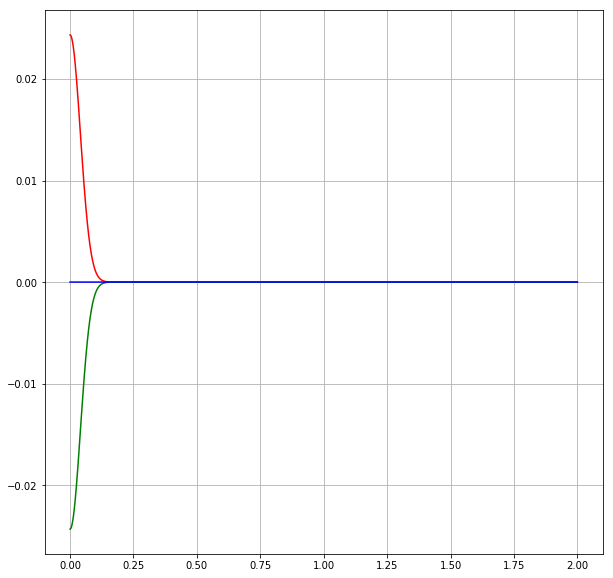

In [26]:
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(r, D11, 'r')
plt.plot(r, D12, 'g')
plt.plot(r, D22, 'b')

plt.show()